## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [1]:
import os, sys
import numpy as np

# write your code here

# Numpy random seed
SEED = 200
np.random.seed(SEED)

DATA_DIR = './data'
TRAIN_DIR = DATA_DIR+ "/" +"train"
TEST_DIR = DATA_DIR+ "/" +"test"

POS_DIR = "pos"
NEG_DIR = "neg"

TRAIN_POS_DIR = TRAIN_DIR + "/" + POS_DIR
TRAIN_NEG_DIR = TRAIN_DIR + "/" + NEG_DIR

TEST_POS_DIR = TEST_DIR + "/" + POS_DIR
TEST_NEG_DIR = TEST_DIR+ "/" + NEG_DIR

print(TRAIN_POS_DIR)
print(TEST_NEG_DIR)


./data/train/pos
./data/test/neg


In [2]:

def read_review(file_path):
    
    f = open(file_path, "r", encoding="utf8")
    return f.read()


def get_file_paths_in_dir(dir_path):
    
    return [ dir_path + "/" + file_path for file_path in os.listdir(dir_path) ]


def read_all_reviews_in_dir(dir_path):
    
    _reviews = []
    file_paths = get_file_paths_in_dir(dir_path)
    
    for file_path in file_paths:
        _reviews.append(read_review(file_path))
    
    return _reviews
    
    

In [3]:

reviews = []
labels = []

rev_train_pos = read_all_reviews_in_dir(TRAIN_POS_DIR)
rev_train_neg = read_all_reviews_in_dir(TRAIN_NEG_DIR)

for i in range(len(rev_train_pos)):
    labels.append(1) #1: positive 0: negative

for i in range(len(rev_train_neg)):
    labels.append(0)
    
reviews.extend(rev_train_pos)
reviews.extend(rev_train_neg)



test_reviews = []
test_labels = []

rev_test_pos = read_all_reviews_in_dir(TEST_POS_DIR)
rev_test_neg = read_all_reviews_in_dir(TEST_NEG_DIR)

test_reviews.extend(rev_test_pos)
test_reviews.extend(rev_test_neg)

for i in range(len(rev_test_pos)):
    test_labels.append(1) #1: positive 0: negative

for i in range(len(rev_test_neg)):
    test_labels.append(0)


In [4]:
print(len(reviews))
print(len(labels))
print(len(test_reviews))
print(len(test_labels))

25000
25000
25000
25000


#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

TRAIN_SIZE = 1000 / len(reviews)


print(TRAIN_SIZE)

x_train, x_val, y_train, y_val = train_test_split(reviews, labels, test_size=1 - TRAIN_SIZE, random_state=SEED)

x_val = x_val[:1000]
y_val = y_val[:1000]


D:\Applications\Python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


0.04


In [6]:
TOP_WORD_COUNT = 5000
SENT_LEN = 100

tokenizer = Tokenizer(num_words=TOP_WORD_COUNT+1, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

tokenizer.fit_on_texts(x_train)


In [7]:

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(test_reviews)
x_val_tokenized = tokenizer.texts_to_sequences(x_val)


In [8]:

x_train_cut = pad_sequences(x_train_tokenized, maxlen=SENT_LEN)
x_test_cut = pad_sequences(x_test_tokenized, maxlen=SENT_LEN)
x_val_cut = pad_sequences(x_val_tokenized, maxlen=SENT_LEN)


In [9]:
print(len(x_train_cut))
print(len(x_test_cut))
print(len(x_val_cut))

1000
25000
1000


In [10]:
len(list(tokenizer.word_index.keys()))

19171

#### c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.

First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [11]:
# write your code here
len(list(tokenizer.word_index.keys()))

19171

In [12]:

GLOVE_FILE_PATH = "./glove.6B.100d.txt"

def load_glove(file_path):
    
    embeddings_index = {}
    f = open(file_path, "r", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    return embeddings_index


In [13]:

word_emb = load_glove(GLOVE_FILE_PATH)


In [14]:
EMBEDDING_DIM = 100
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = word_emb.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [15]:
embedding_matrix.shape

(19172, 100)

In [16]:

def convert_to_two_labels(label_arr):
    
    _lab_arr = []
    for i in range(len(label_arr)):
        if label_arr[i] == 0:
            _lab_arr.append(np.array([0, 1]))
        else:
            _lab_arr.append(np.array([1, 0]))
    
    return np.array(_lab_arr)


In [17]:
y_train = convert_to_two_labels(y_train)
y_val = convert_to_two_labels(y_val)
y_test = convert_to_two_labels(test_labels)

#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

#### Architecture

Over here, I have used an embedding layer with the weights being set to the **embedding_matrix** we created using **Glove**. This layer is also set to untrainable as Glove is already pretrained and we don't want it to get updated with the weights during the backpropagation. 

This has one embedding layer with a DenseLayer (2 neurons and softmax for probabilities).
RMSProp has been used with a small learning rate of **0.00001** and categorical crossentropy as the loss function as this is a categorical task. 

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM


# write your code here
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=SENT_LEN,
                            trainable=False)


In [19]:

import keras

model = Sequential()

model.add(embedding_layer)

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:

epochs = 600
batch_size = 512

history = model.fit(x_train_cut,
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_val_cut, y_val),
                    verbose=1)


Train on 1000 samples, validate on 1000 samples
Epoch 1/600
1000/1000 [==============================] - 0s 346us/step - loss: 0.8543 - acc: 0.4870 - val_loss: 0.8034 - val_acc: 0.4950
Epoch 2/600
1000/1000 [==============================] - 0s 20us/step - loss: 0.8193 - acc: 0.4850 - val_loss: 0.7855 - val_acc: 0.5010
Epoch 3/600
1000/1000 [==============================] - 0s 18us/step - loss: 0.8021 - acc: 0.4820 - val_loss: 0.7749 - val_acc: 0.4980
Epoch 4/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.7911 - acc: 0.4670 - val_loss: 0.7679 - val_acc: 0.4990
Epoch 5/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.7835 - acc: 0.4810 - val_loss: 0.7632 - val_acc: 0.4970
Epoch 6/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.7779 - acc: 0.4840 - val_loss: 0.7600 - val_acc: 0.5020
Epoch 7/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.7740 - acc: 0.4790 - val_loss: 0.7580 - val_acc: 0.5030

Epoch 120/600
1000/1000 [==============================] - 0s 18us/step - loss: 0.6125 - acc: 0.6640 - val_loss: 0.7294 - val_acc: 0.5380
Epoch 121/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.6112 - acc: 0.6650 - val_loss: 0.7291 - val_acc: 0.5380
Epoch 122/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.6099 - acc: 0.6680 - val_loss: 0.7290 - val_acc: 0.5380
Epoch 123/600
1000/1000 [==============================] - 0s 20us/step - loss: 0.6089 - acc: 0.6700 - val_loss: 0.7287 - val_acc: 0.5370
Epoch 124/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.6080 - acc: 0.6740 - val_loss: 0.7285 - val_acc: 0.5370
Epoch 125/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.6062 - acc: 0.6740 - val_loss: 0.7284 - val_acc: 0.5380
Epoch 126/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.6050 - acc: 0.6760 - val_loss: 0.7283 - val_acc: 0.5430
Epoch 127/600
1000/1000 [=========

1000/1000 [==============================] - 0s 16us/step - loss: 0.4838 - acc: 0.8150 - val_loss: 0.7145 - val_acc: 0.5620
Epoch 239/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.4829 - acc: 0.8170 - val_loss: 0.7144 - val_acc: 0.5650
Epoch 240/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.4820 - acc: 0.8190 - val_loss: 0.7144 - val_acc: 0.5640
Epoch 241/600
1000/1000 [==============================] - 0s 18us/step - loss: 0.4810 - acc: 0.8190 - val_loss: 0.7142 - val_acc: 0.5610
Epoch 242/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.4802 - acc: 0.8200 - val_loss: 0.7142 - val_acc: 0.5640
Epoch 243/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.4792 - acc: 0.8190 - val_loss: 0.7140 - val_acc: 0.5640
Epoch 244/600
1000/1000 [==============================] - 0s 19us/step - loss: 0.4782 - acc: 0.8200 - val_loss: 0.7139 - val_acc: 0.5650
Epoch 245/600
1000/1000 [=======================

1000/1000 [==============================] - 0s 21us/step - loss: 0.3860 - acc: 0.9100 - val_loss: 0.7082 - val_acc: 0.5690
Epoch 357/600
1000/1000 [==============================] - 0s 26us/step - loss: 0.3852 - acc: 0.9140 - val_loss: 0.7083 - val_acc: 0.5680
Epoch 358/600
1000/1000 [==============================] - 0s 22us/step - loss: 0.3846 - acc: 0.9110 - val_loss: 0.7082 - val_acc: 0.5690
Epoch 359/600
1000/1000 [==============================] - 0s 18us/step - loss: 0.3837 - acc: 0.9140 - val_loss: 0.7082 - val_acc: 0.5690
Epoch 360/600
1000/1000 [==============================] - 0s 18us/step - loss: 0.3831 - acc: 0.9140 - val_loss: 0.7083 - val_acc: 0.5690
Epoch 361/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.3823 - acc: 0.9140 - val_loss: 0.7082 - val_acc: 0.5680
Epoch 362/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.3816 - acc: 0.9140 - val_loss: 0.7081 - val_acc: 0.5690
Epoch 363/600
1000/1000 [=======================

1000/1000 [==============================] - 0s 17us/step - loss: 0.3084 - acc: 0.9690 - val_loss: 0.7080 - val_acc: 0.5880
Epoch 475/600
1000/1000 [==============================] - 0s 21us/step - loss: 0.3076 - acc: 0.9700 - val_loss: 0.7082 - val_acc: 0.5900
Epoch 476/600
1000/1000 [==============================] - 0s 19us/step - loss: 0.3071 - acc: 0.9710 - val_loss: 0.7081 - val_acc: 0.5880
Epoch 477/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.3065 - acc: 0.9710 - val_loss: 0.7083 - val_acc: 0.5870
Epoch 478/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.3059 - acc: 0.9710 - val_loss: 0.7081 - val_acc: 0.5880
Epoch 479/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.3052 - acc: 0.9730 - val_loss: 0.7082 - val_acc: 0.5870
Epoch 480/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.3050 - acc: 0.9720 - val_loss: 0.7084 - val_acc: 0.5890
Epoch 481/600
1000/1000 [=======================

1000/1000 [==============================] - 0s 15us/step - loss: 0.2474 - acc: 0.9870 - val_loss: 0.7122 - val_acc: 0.5840
Epoch 593/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.2470 - acc: 0.9870 - val_loss: 0.7124 - val_acc: 0.5840
Epoch 594/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.2466 - acc: 0.9870 - val_loss: 0.7123 - val_acc: 0.5850
Epoch 595/600
1000/1000 [==============================] - 0s 15us/step - loss: 0.2462 - acc: 0.9870 - val_loss: 0.7126 - val_acc: 0.5850
Epoch 596/600
1000/1000 [==============================] - 0s 17us/step - loss: 0.2458 - acc: 0.9870 - val_loss: 0.7124 - val_acc: 0.5850
Epoch 597/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.2452 - acc: 0.9870 - val_loss: 0.7125 - val_acc: 0.5860
Epoch 598/600
1000/1000 [==============================] - 0s 16us/step - loss: 0.2456 - acc: 0.9860 - val_loss: 0.7127 - val_acc: 0.5850
Epoch 599/600
1000/1000 [=======================

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

def plot_train_val_acc_curve(_hist):
    
    plt.plot(_hist.history['acc'])
    plt.plot(_hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt.show()


def plot_train_val_loss_curve(_hist):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    

def plot_roc_curve(_y, _y_hat):
    
    fpr, tpr, thresholds = roc_curve(_y.argmax(axis=1).ravel(), first_arg(_y_hat))
    auc_simple = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_simple))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    return plt.show()


def plot_precision_recall_curve(labels, predictions, classifier_name=None):
    
    title = "Precision-Recall curve"
    if classifier_name is not None:
        title = "Precision-Recall curve for {} predictions".format(classifier_name)
        
    precision, recall, thresholds = precision_recall_curve(labels, predictions)
    
    average_precision = average_precision_score(labels, predictions)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.suptitle('Precision-Recall curve for {0}: AP={1:0.2f}'.format(classifier_name, average_precision))
    
    plot = plt.subplot(1, 2, 2)
    
    plot.step(recall, precision, color='b', alpha=0.2, where='post')
    
    plot.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plot.set_xlabel('Recall')
    plot.set_ylabel('Precision')
    plot.set_ylim([0.0, 1.05])
    plot.set_xlim([0.0, 1.0])
       
    return plot


def first_arg(arr):
    
    _arr = []
    
    for i in range(len(arr)):
        _arr.append(arr[i][1])
    
    return _arr
    

#### Accuracy

Over here, the train accuracy is much faster than the validation accuracy. The validation accuracy goes up until around 400 epochs after which is stays flat. This means the training could be stopped at around 400 epochs. 

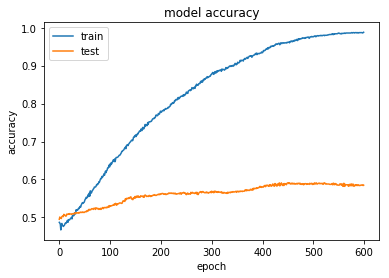

In [22]:
plot_train_val_acc_curve(history)

### Loss plot

The loss drops rapidly at the start and then decreases slowly over time until around 400 epochs after which is stays flat / goes up very slightly. 

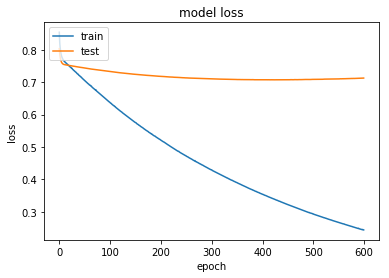

In [23]:

plot_train_val_loss_curve(history)

In [24]:

model_predictions = model.predict(x_test_cut)

score = model.evaluate(x_test_cut, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.7067197920227051
Test accuracy: 0.59076


### ROC & AUC

The AUC is quite low at **

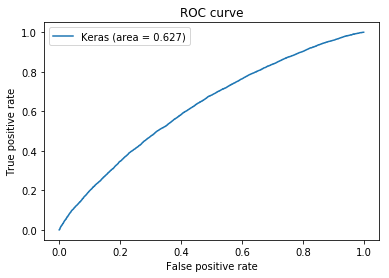

In [25]:
plot_roc_curve(y_test,  model_predictions)

Axes(0.547727,0.125;0.352273x0.755)


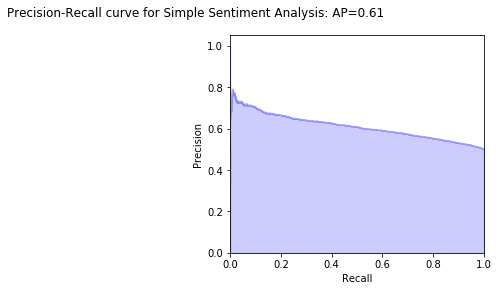

In [26]:

print(plot_precision_recall_curve(first_arg(y_test), first_arg(model_predictions), "Simple Sentiment Analysis"))


#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

In [27]:

x_train_lstm = x_train_cut.reshape((x_train_cut.shape[0], 1, x_train_cut.shape[1]))
x_val_lstm = x_val_cut.reshape((x_val_cut.shape[0], 1, x_val_cut.shape[1]))


In [28]:

model = Sequential()

model.add(embedding_layer)
model.add(LSTM(400, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))

model.add(Dense(256))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1917200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               801600    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               102656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 2,821,970
Trainable params: 904,770
Non-trainable params: 1,917,200
_________________________________________________________________


In [30]:

epochs = 600
batch_size = 512

history = model.fit(x_train_cut,
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_val_cut, y_val),
                    verbose=1)


Train on 1000 samples, validate on 1000 samples
Epoch 1/600
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6972 - acc: 0.5080 - val_loss: 0.6923 - val_acc: 0.5170
Epoch 2/600
1000/1000 [==============================] - 1s 660us/step - loss: 0.6995 - acc: 0.4820 - val_loss: 0.6915 - val_acc: 0.5280
Epoch 3/600
1000/1000 [==============================] - 1s 642us/step - loss: 0.6940 - acc: 0.5210 - val_loss: 0.6908 - val_acc: 0.5190
Epoch 4/600
1000/1000 [==============================] - 1s 656us/step - loss: 0.6941 - acc: 0.5110 - val_loss: 0.6901 - val_acc: 0.5320
Epoch 5/600
1000/1000 [==============================] - 1s 645us/step - loss: 0.6942 - acc: 0.5200 - val_loss: 0.6896 - val_acc: 0.5350
Epoch 6/600
1000/1000 [==============================] - 1s 658us/step - loss: 0.6904 - acc: 0.5060 - val_loss: 0.6890 - val_acc: 0.5410
Epoch 7/600
1000/1000 [==============================] - 1s 645us/step - loss: 0.6900 - acc: 0.5200 - val_loss: 0.6885 - val_acc: 0.

1000/1000 [==============================] - 1s 677us/step - loss: 0.6175 - acc: 0.6720 - val_loss: 0.6354 - val_acc: 0.6470
Epoch 120/600
1000/1000 [==============================] - 1s 656us/step - loss: 0.6167 - acc: 0.6670 - val_loss: 0.6348 - val_acc: 0.6470
Epoch 121/600
1000/1000 [==============================] - 1s 677us/step - loss: 0.6175 - acc: 0.6750 - val_loss: 0.6344 - val_acc: 0.6480
Epoch 122/600
1000/1000 [==============================] - 1s 672us/step - loss: 0.6154 - acc: 0.6750 - val_loss: 0.6335 - val_acc: 0.6510
Epoch 123/600
1000/1000 [==============================] - 1s 681us/step - loss: 0.6170 - acc: 0.6680 - val_loss: 0.6329 - val_acc: 0.6500
Epoch 124/600
1000/1000 [==============================] - 1s 702us/step - loss: 0.6152 - acc: 0.6770 - val_loss: 0.6323 - val_acc: 0.6530
Epoch 125/600
1000/1000 [==============================] - 1s 646us/step - loss: 0.6118 - acc: 0.6870 - val_loss: 0.6317 - val_acc: 0.6540
Epoch 126/600
1000/1000 [================

1000/1000 [==============================] - 1s 654us/step - loss: 0.5429 - acc: 0.7270 - val_loss: 0.5922 - val_acc: 0.6810
Epoch 179/600
1000/1000 [==============================] - 1s 648us/step - loss: 0.5413 - acc: 0.7350 - val_loss: 0.5898 - val_acc: 0.6820
Epoch 180/600
1000/1000 [==============================] - 1s 657us/step - loss: 0.5416 - acc: 0.7260 - val_loss: 0.5882 - val_acc: 0.6830
Epoch 181/600
1000/1000 [==============================] - 1s 651us/step - loss: 0.5396 - acc: 0.7330 - val_loss: 0.5898 - val_acc: 0.6830
Epoch 182/600
1000/1000 [==============================] - 1s 646us/step - loss: 0.5419 - acc: 0.7390 - val_loss: 0.5882 - val_acc: 0.6850
Epoch 183/600
1000/1000 [==============================] - 1s 647us/step - loss: 0.5411 - acc: 0.7380 - val_loss: 0.5880 - val_acc: 0.6850
Epoch 184/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.5397 - acc: 0.7300 - val_loss: 0.5858 - val_acc: 0.6930
Epoch 185/600
1000/1000 [================

1000/1000 [==============================] - 1s 644us/step - loss: 0.4999 - acc: 0.7550 - val_loss: 0.5690 - val_acc: 0.7120
Epoch 238/600
1000/1000 [==============================] - 1s 651us/step - loss: 0.4993 - acc: 0.7500 - val_loss: 0.5628 - val_acc: 0.7160
Epoch 239/600
1000/1000 [==============================] - 1s 655us/step - loss: 0.4924 - acc: 0.7570 - val_loss: 0.5592 - val_acc: 0.7240
Epoch 240/600
1000/1000 [==============================] - 1s 645us/step - loss: 0.4885 - acc: 0.7520 - val_loss: 0.5593 - val_acc: 0.7260
Epoch 241/600
1000/1000 [==============================] - 1s 651us/step - loss: 0.4902 - acc: 0.7540 - val_loss: 0.5589 - val_acc: 0.7260
Epoch 242/600
1000/1000 [==============================] - 1s 649us/step - loss: 0.4903 - acc: 0.7550 - val_loss: 0.5628 - val_acc: 0.7210
Epoch 243/600
1000/1000 [==============================] - 1s 644us/step - loss: 0.4999 - acc: 0.7650 - val_loss: 0.5667 - val_acc: 0.7180
Epoch 244/600
1000/1000 [================

1000/1000 [==============================] - 1s 673us/step - loss: 0.4701 - acc: 0.7710 - val_loss: 0.5494 - val_acc: 0.7370
Epoch 297/600
1000/1000 [==============================] - 1s 658us/step - loss: 0.4659 - acc: 0.7770 - val_loss: 0.5516 - val_acc: 0.7240
Epoch 298/600
1000/1000 [==============================] - 1s 704us/step - loss: 0.4867 - acc: 0.7610 - val_loss: 0.5625 - val_acc: 0.7240
Epoch 299/600
1000/1000 [==============================] - 1s 661us/step - loss: 0.4714 - acc: 0.7740 - val_loss: 0.5488 - val_acc: 0.7350
Epoch 300/600
1000/1000 [==============================] - 1s 657us/step - loss: 0.4639 - acc: 0.7710 - val_loss: 0.5491 - val_acc: 0.7370
Epoch 301/600
1000/1000 [==============================] - 1s 649us/step - loss: 0.4679 - acc: 0.7750 - val_loss: 0.5505 - val_acc: 0.7350
Epoch 302/600
1000/1000 [==============================] - 1s 642us/step - loss: 0.4659 - acc: 0.7690 - val_loss: 0.5488 - val_acc: 0.7330
Epoch 303/600
1000/1000 [================

1000/1000 [==============================] - 1s 713us/step - loss: 0.4545 - acc: 0.7810 - val_loss: 0.5435 - val_acc: 0.7430
Epoch 356/600
1000/1000 [==============================] - 1s 683us/step - loss: 0.4520 - acc: 0.7830 - val_loss: 0.5512 - val_acc: 0.7300
Epoch 357/600
1000/1000 [==============================] - 1s 652us/step - loss: 0.4526 - acc: 0.7780 - val_loss: 0.5435 - val_acc: 0.7390
Epoch 358/600
1000/1000 [==============================] - 1s 644us/step - loss: 0.4611 - acc: 0.7730 - val_loss: 0.5635 - val_acc: 0.7320
Epoch 359/600
1000/1000 [==============================] - 1s 671us/step - loss: 0.4693 - acc: 0.7650 - val_loss: 0.5468 - val_acc: 0.7330
Epoch 360/600
1000/1000 [==============================] - 1s 671us/step - loss: 0.4506 - acc: 0.7900 - val_loss: 0.5528 - val_acc: 0.7290
Epoch 361/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.4582 - acc: 0.7820 - val_loss: 0.5455 - val_acc: 0.7380
Epoch 362/600
1000/1000 [================

1000/1000 [==============================] - 1s 651us/step - loss: 0.4656 - acc: 0.7750 - val_loss: 0.5578 - val_acc: 0.7350
Epoch 415/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.4508 - acc: 0.7800 - val_loss: 0.5395 - val_acc: 0.7440
Epoch 416/600
1000/1000 [==============================] - 1s 646us/step - loss: 0.4371 - acc: 0.7930 - val_loss: 0.5470 - val_acc: 0.7350
Epoch 417/600
1000/1000 [==============================] - 1s 651us/step - loss: 0.4378 - acc: 0.7970 - val_loss: 0.5391 - val_acc: 0.7420
Epoch 418/600
1000/1000 [==============================] - 1s 648us/step - loss: 0.4351 - acc: 0.7860 - val_loss: 0.5394 - val_acc: 0.7390
Epoch 419/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.4352 - acc: 0.7920 - val_loss: 0.5430 - val_acc: 0.7370
Epoch 420/600
1000/1000 [==============================] - 1s 649us/step - loss: 0.4429 - acc: 0.7860 - val_loss: 0.5536 - val_acc: 0.7310
Epoch 421/600
1000/1000 [================

1000/1000 [==============================] - 1s 645us/step - loss: 0.4313 - acc: 0.8020 - val_loss: 0.5461 - val_acc: 0.7360
Epoch 474/600
1000/1000 [==============================] - 1s 655us/step - loss: 0.4244 - acc: 0.8000 - val_loss: 0.5382 - val_acc: 0.7420
Epoch 475/600
1000/1000 [==============================] - 1s 652us/step - loss: 0.4230 - acc: 0.8010 - val_loss: 0.5385 - val_acc: 0.7430
Epoch 476/600
1000/1000 [==============================] - 1s 657us/step - loss: 0.4271 - acc: 0.7970 - val_loss: 0.5443 - val_acc: 0.7390
Epoch 477/600
1000/1000 [==============================] - 1s 659us/step - loss: 0.4238 - acc: 0.8040 - val_loss: 0.5429 - val_acc: 0.7480
Epoch 478/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.4388 - acc: 0.7910 - val_loss: 0.5666 - val_acc: 0.7320
Epoch 479/600
1000/1000 [==============================] - 1s 649us/step - loss: 0.4390 - acc: 0.7910 - val_loss: 0.5397 - val_acc: 0.7470
Epoch 480/600
1000/1000 [================

1000/1000 [==============================] - 1s 657us/step - loss: 0.4169 - acc: 0.8020 - val_loss: 0.5471 - val_acc: 0.7360
Epoch 533/600
1000/1000 [==============================] - 1s 648us/step - loss: 0.4245 - acc: 0.8050 - val_loss: 0.5653 - val_acc: 0.7280
Epoch 534/600
1000/1000 [==============================] - 1s 657us/step - loss: 0.4601 - acc: 0.7840 - val_loss: 0.5517 - val_acc: 0.7320
Epoch 535/600
1000/1000 [==============================] - 1s 651us/step - loss: 0.4213 - acc: 0.8050 - val_loss: 0.5382 - val_acc: 0.7400
Epoch 536/600
1000/1000 [==============================] - 1s 646us/step - loss: 0.4157 - acc: 0.8070 - val_loss: 0.5434 - val_acc: 0.7380
Epoch 537/600
1000/1000 [==============================] - 1s 655us/step - loss: 0.4113 - acc: 0.8090 - val_loss: 0.5392 - val_acc: 0.7510
Epoch 538/600
1000/1000 [==============================] - 1s 650us/step - loss: 0.4131 - acc: 0.8070 - val_loss: 0.5376 - val_acc: 0.7460
Epoch 539/600
1000/1000 [================

1000/1000 [==============================] - 1s 658us/step - loss: 0.4119 - acc: 0.8120 - val_loss: 0.5409 - val_acc: 0.7400
Epoch 592/600
1000/1000 [==============================] - 1s 682us/step - loss: 0.4028 - acc: 0.8090 - val_loss: 0.5397 - val_acc: 0.7520
Epoch 593/600
1000/1000 [==============================] - 1s 652us/step - loss: 0.4016 - acc: 0.8160 - val_loss: 0.5452 - val_acc: 0.7330
Epoch 594/600
1000/1000 [==============================] - 1s 662us/step - loss: 0.4091 - acc: 0.8170 - val_loss: 0.5508 - val_acc: 0.7320
Epoch 595/600
1000/1000 [==============================] - 1s 648us/step - loss: 0.4080 - acc: 0.8110 - val_loss: 0.5462 - val_acc: 0.7300
Epoch 596/600
1000/1000 [==============================] - 1s 643us/step - loss: 0.4003 - acc: 0.8100 - val_loss: 0.5468 - val_acc: 0.7460
Epoch 597/600
1000/1000 [==============================] - 1s 645us/step - loss: 0.4132 - acc: 0.8070 - val_loss: 0.5533 - val_acc: 0.7460
Epoch 598/600
1000/1000 [================

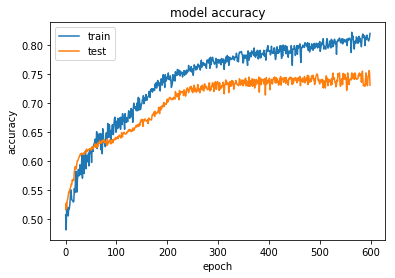

In [31]:
plot_train_val_acc_curve(history)

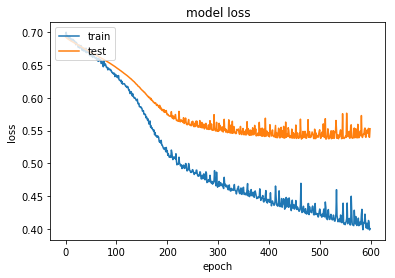

In [32]:

plot_train_val_loss_curve(history)

In [33]:

model_predictions = model.predict(x_test_cut)

score = model.evaluate(x_test_cut, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.5261531844139099
Test accuracy: 0.74952


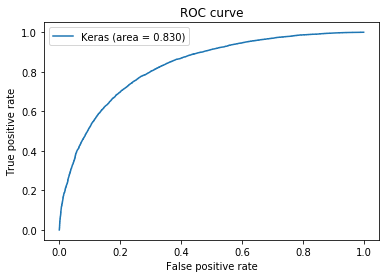

In [34]:
plot_roc_curve(y_test,  model_predictions)

Axes(0.547727,0.125;0.352273x0.755)


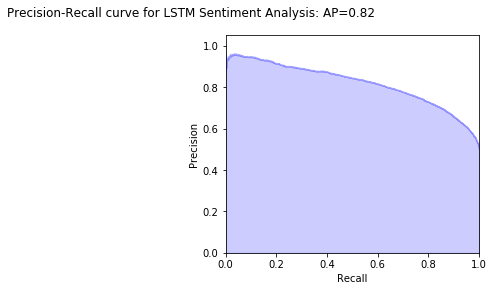

In [35]:

print(plot_precision_recall_curve(first_arg(y_test), first_arg(model_predictions), "LSTM Sentiment Analysis"))
